# Interpolate everyting!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import h5py
from scipy.interpolate import CubicSpline

In [3]:
def unpack_hdf5(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = unpack_hdf5_(f)
    return data

def unpack_hdf5_(group):
    data = {}
    for key in group.keys():
        if isinstance(group[key], h5py.Group):
            data[key] = unpack_hdf5_(group[key])
        else:
            data[key] = group[key][()]
    return data

In [4]:
# Load ground truth data

aran_hh = pd.read_csv('../data/raw/ref_data/cph1_aran_hh.csv', sep=';', encoding='unicode_escape')
aran_vh = pd.read_csv('../data/raw/ref_data/cph1_aran_vh.csv', sep=';', encoding='unicode_escape')

fric_hh = pd.read_csv('../data/raw/ref_data/cph1_fric_hh.csv', sep=';', encoding='unicode_escape')
fric_vh = pd.read_csv('../data/raw/ref_data/cph1_fric_vh.csv', sep=';', encoding='unicode_escape')

p79_hh = pd.read_csv('../data/raw/ref_data/cph1_zp_hh.csv', sep=';', encoding='unicode_escape')
p79_vh = pd.read_csv('../data/raw/ref_data/cph1_zp_vh.csv', sep=';', encoding='unicode_escape')

mpd_hh = pd.read_csv('../data/raw/ref_data/cph1_iri_mpd_rut_hh.csv', sep=';', encoding='unicode_escape')
mpd_vh = pd.read_csv('../data/raw/ref_data/cph1_iri_mpd_rut_vh.csv', sep=';', encoding='unicode_escape')

In [5]:
autopi_hh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_HH.hdf5')
autopi_vh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_VH.hdf5')

Since all sensors and measurements are recorded at different rates, the data is not aligned in time. Hence we create time-aligned data by interpolating each attribute.

Since the ground truth data contains data from a much larger trip, we first need to cut out the section of the trip which corresponds to the training data from autopi.

In [6]:
def find_best_start_and_end_indeces(trip: np.ndarray, section: np.ndarray, kind="l1"):
    # Find the start and end indeces of the section data that are closest to the trip data
    lon_a, lat_a = trip[:,0], trip[:,1]
    lon_b, lat_b = section[:,0], section[:,1]
    if kind == "l1":
        start_index = np.argmin(np.abs(lon_a - lon_b[0]) + np.abs(lat_a - lat_b[0]))
        end_index = np.argmin(np.abs(lon_a - lon_b[-1]) + np.abs(lat_a - lat_b[-1]))
    elif kind == "l2":
        start_index = np.argmin(np.sqrt((lon_a - lon_b[0])**2 + (lat_a - lat_b[0])**2))
        end_index = np.argmin(np.sqrt((lon_a - lon_b[-1])**2 + (lat_a - lat_b[-1])**2))

    return start_index, end_index

In [7]:
def interpolate(x: np.ndarray, y: np.ndarray, kind="cubic"):
    # Interpolate data to match the time
    match kind:
        case "cubic":
            f = CubicSpline(x, y)
        case _:
            raise ValueError(f"Interpolation method {kind} not supported")
    return f

In [8]:
def cut_dataframe_by_indeces(df, start, end):
    return df.iloc[start:end]

First (a little crude) cut the sections of the ground truth by the sections found in the autopi dataset.

In [9]:
cut_aran_hh = cut_dataframe_by_indeces(
    aran_hh, *find_best_start_and_end_indeces(
        aran_hh[["Lon", "Lat"]].values,
        autopi_hh["aran"]['trip_1']['pass_1']["GPS"][:, ::-1]
    )
)
cut_aran_vh = cut_dataframe_by_indeces(
    aran_vh, *find_best_start_and_end_indeces(
        aran_vh[["Lon", "Lat"]].values,
        autopi_vh["aran"]['trip_1']['pass_1']["GPS"][:, ::-1]
    )
)

cut_p79_hh = cut_dataframe_by_indeces(
    p79_hh, *find_best_start_and_end_indeces(
        p79_hh[["Lon", "Lat"]].values,
        autopi_hh["p79"]['trip_1']['pass_1']["GPS"][:, ::-1]
    )
)
cut_p79_vh = cut_dataframe_by_indeces(
    p79_vh, *find_best_start_and_end_indeces(
        p79_vh[["Lon", "Lat"]].values,
        autopi_vh["p79"]['trip_1']['pass_1']["GPS"][:, ::-1]
    )
)

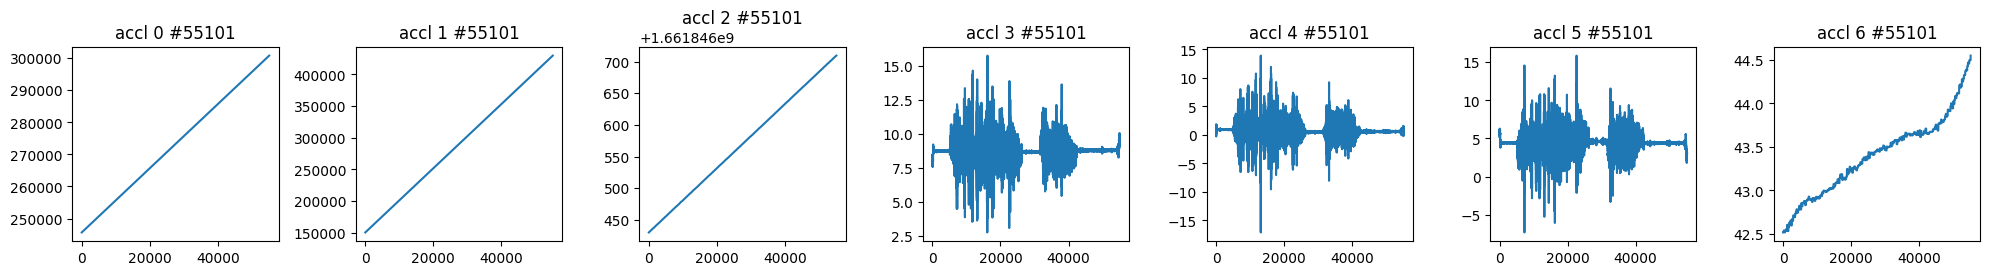

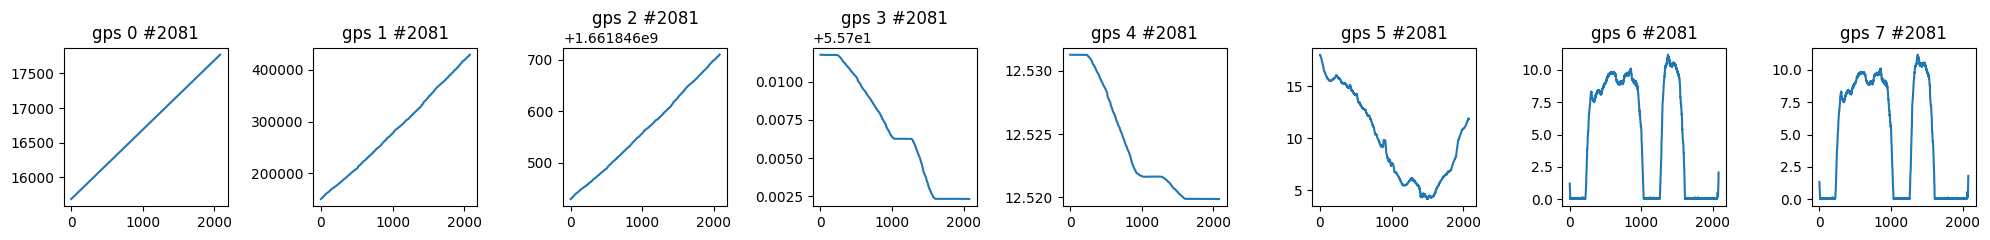

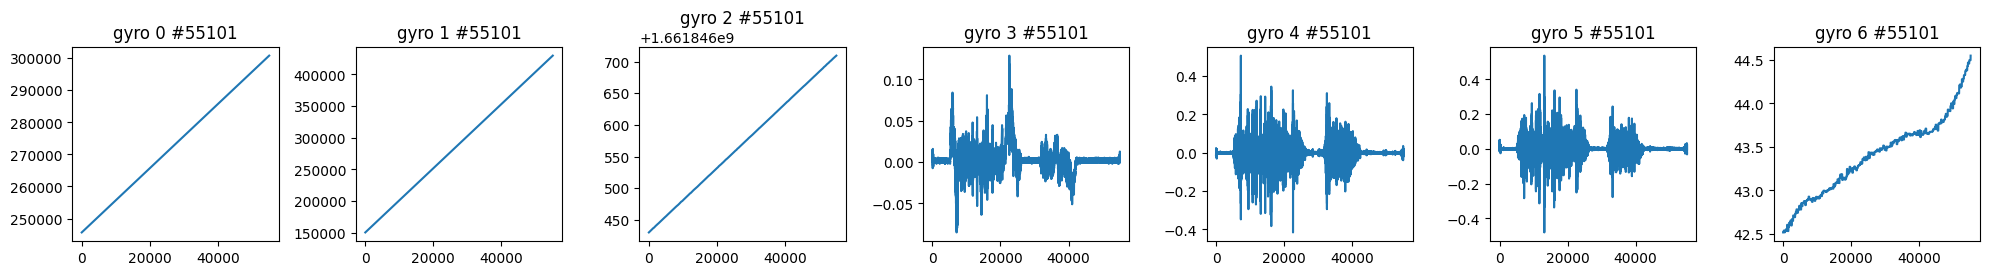

In [11]:
trip = 1
pass_ = 1

for key, autopi_measurements in autopi_hh["gopro"][f"trip_{trip}"][f"pass_{pass_}"].items():
    # Plot one figure for each attribute in data

    fig, ax = plt.subplots(1, autopi_measurements.shape[1], figsize=(20, 20/autopi_measurements.shape[1]))

    for i in range(autopi_measurements.shape[1]):
        ax[i].plot(autopi_measurements[:,i])
        ax[i].set_title(f"{key} {i} #{len(autopi_measurements)}")
    plt.tight_layout()
    plt.show()


In [9]:
class InterpolationClass:

    def interpolate(self, x: np.ndarray, y: np.ndarray, kind="cubic"):
        # Interpolate data to match the time
        match kind:
            case "cubic":
                f = CubicSpline(x, y)
            case _:
                raise ValueError(f"Interpolation method {kind} not supported")
        return f

    def normalise(self, column):
        return (column - column.min()) / (column.max() - column.min())

class InterpolateP79(InterpolationClass):
    laser_columns = (f" Laser {i} [mm]" for i in range(1, 26))

    def __init__(self, df: pd.DataFrame, kind="cubic"):
        self.df = df
        self.kind = kind
        
        self.lasers = self.interpolate(self.normalise(df["Distance [m]"]), df[self.laser_columns], kind=kind)
        self.gps = self.interpolate(self.normalise(df["Distance [m]"]), df[["Lon", "Lat"]], kind=kind)


class InterpolateAutopiPass(InterpolationClass):

    def __init__(self, data: dict, kind="cubic"):
        self.data = data
        self.kind = kind
        
        self.gps = self.interpolate(self.normalise(data["gps"][:, 0]), data["gps"][:, 1:], kind=kind)


class InterpolateAutopi:

    def __init__(self, data: dict, kind="cubic"):
        self.data = data
        self.kind = kind

        # self.lasers = self.interpolate(data["Distance"], data["Laser"], kind=kind)
        self.passes = {}
        for trip_name, trip in data.items():
            self.passes[trip_name] = {}
            for pass_name, pass_ in trip.items():
                self.passes[trip_name][pass_name] = InterpolateAutopiPass(pass_, kind=kind)
    
    def __getitem__(self, key):
        return self.passes[key[0]][key[1]]

In [10]:
# Interpolate P79 laser data to match with the corresponding distance measurements
p79_hh_interp = InterpolateP79(cut_p79_hh)

# Interpolate AutoPi data to match with the corresponding time measurements
autopi_hh_interp = InterpolateAutopi(autopi_hh['GM'])

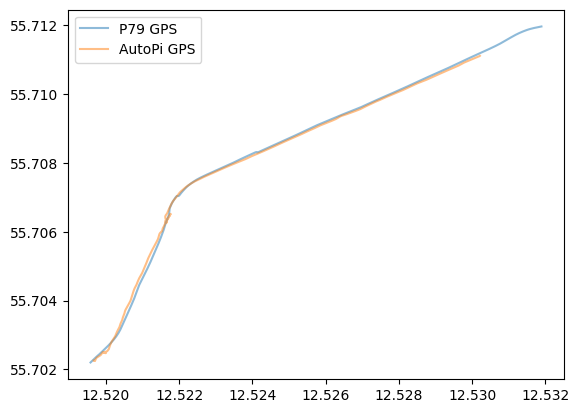

In [11]:
t = np.linspace(0, 1, 500)
gps_p79 = p79_hh_interp.gps(t)
gps_autopi = autopi_hh_interp['16006', 'pass_15'].gps(t)

fig, ax = plt.subplots()
ax.plot(gps_p79[:,0], gps_p79[:,1], label="P79 GPS", alpha=0.5)
ax.plot(gps_autopi[:,1], gps_autopi[:,0], label="AutoPi GPS", alpha=0.5)
#ax.plot(cut_p79_hh["Lon"], cut_p79_hh["Lat"], label="Original GPS", alpha=0.5)
ax.legend()
plt.show()
